In [1]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
import random
from keras.utils import to_categorical
from google.colab import drive,files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Set the seed for TensorFlow
tf.random.set_seed(1)
# Set the seed for NumPy
np.random.seed(1)
# Set the seed for the Python random module
random.seed(1)

Connect to Google drive 

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#os.mkdir('gdrive/MyDrive/data')
#os.mkdir('gdrive/MyDrive/data/Resized-cocci')
#os.mkdir('gdrive/MyDrive/data/Resized-healthy')
#os.mkdir('gdrive/MyDrive/data/Resized-salmo')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/cocci.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/healthy.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/salmo.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#def resize(folder,save_to):
#  i= 0
#  images = glob.glob(folder + "/*.jpg")
#  for img in  images[:500]:
#    image= Image.open(img)
#    image= image.resize((224,224))
#    image.save(f"{save_to}/resized{i}.jpg")
#    i+=1
#  print(f'successfully saved to {save_to}')

In [ ]:
#resize('gdrive/MyDrive/data/salmo','gdrive/MyDrive/data/Resized-salmo-224')
#resize('gdrive/MyDrive/data/healthy','gdrive/MyDrive/data/Resized-healthy-224')
#resize('gdrive/MyDrive/data/cocci','gdrive/MyDrive/data/Resized-cocci-224')

Reading data from drive

In [3]:
# We will take only 500 images of each class 
cocci = glob.glob('/content/gdrive/MyDrive/data/Resized-cocci/*.jpg')[:500]
healthy = glob.glob('/content/gdrive/MyDrive/data/Resized-healthy/*.jpg')[:500]
salmo = glob.glob('/content/gdrive/MyDrive/data/Resized-salmo/*.jpg')[:500]

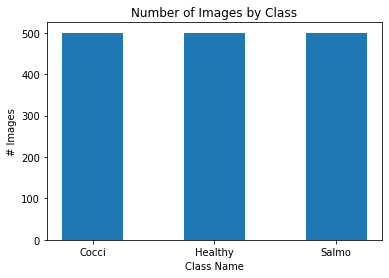

In [4]:
dict_ = {"Cocci":len(cocci) ,
         "Healthy":len(healthy),
         "Salmo":len(salmo)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

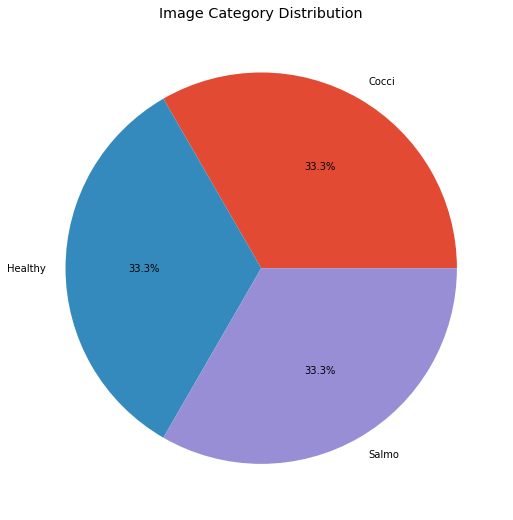

In [5]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [6]:
labels = []
data =[] 

In [7]:
def prepare_images(array,class_no):
  for img in array:
    x = load_img(img)
    x = img_to_array(x)
    data.append(x)
    labels.append(class_no)

In [8]:
prepare_images(cocci,0)
prepare_images(healthy,1)
prepare_images(salmo,2)

In [9]:
data = np.array(data)
labels = to_categorical(labels)

In [10]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=1,shuffle=True)

**Transfer** **Learning**

In [11]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3),include_top=False, # Transfer learning
                                                weights="imagenet")

In [13]:
# freeze the base model 
base_model.trainable = False

In [14]:
# Add a classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               123008    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,119,747
Trainable params: 123,395
Non-trainable params: 2,996,352
_________________________________________________________________


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),  metrics=['accuracy'])

In [18]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
38/38 [==============================] - 14s 135ms/step - loss: 0.2351 - accuracy: 0.9100 - val_loss: 0.0711 - val_accuracy: 0.9800
Epoch 2/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0442 - accuracy: 0.9858 - val_loss: 0.0745 - val_accuracy: 0.9767
Epoch 3/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0231 - accuracy: 0.9950 - val_loss: 0.0635 - val_accuracy: 0.9800
Epoch 4/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0144 - accuracy: 0.9992 - val_loss: 0.0634 - val_accuracy: 0.9800
Epoch 5/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9767
Epoch 6/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0678 - val_accuracy: 0.9767
Epoch 7/100
38/38 [==============================] - 2s 52ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9800
Epoc

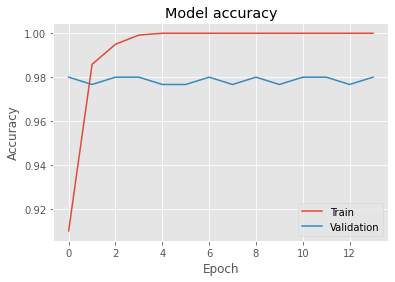

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [20]:
# load the best model
best_model_tl = keras.models.load_model('best_model_tl.h5')

In [21]:
# Get predictions
y_pred = best_model_tl.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

10/10 [==============================] - 2s 45ms/step

--- Confusion Matrix ---

[[ 95   0   0]
 [  1 104   2]
 [  0   3  95]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        95
           1       0.97      0.97      0.97       107
           2       0.98      0.97      0.97        98

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



**Fine**-**Tuning**

In [22]:
# Unfreeze some layers in the base model
base_model.trainable = True

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),  metrics=['accuracy'])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_fn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [25]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
38/38 [==============================] - 15s 202ms/step - loss: 0.1245 - accuracy: 0.9550 - val_loss: 0.0822 - val_accuracy: 0.9700
Epoch 2/100
38/38 [==============================] - 6s 153ms/step - loss: 0.0185 - accuracy: 0.9958 - val_loss: 0.0878 - val_accuracy: 0.9767
Epoch 3/100
38/38 [==============================] - 5s 142ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.0924 - val_accuracy: 0.9733
Epoch 4/100
38/38 [==============================] - 5s 139ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.1002 - val_accuracy: 0.9733
Epoch 5/100
38/38 [==============================] - 5s 140ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0920 - val_accuracy: 0.9733
Epoch 6/100
38/38 [==============================] - 5s 141ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0927 - val_accuracy: 0.9767
Epoch 7/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1158 - val_accuracy: 0.970

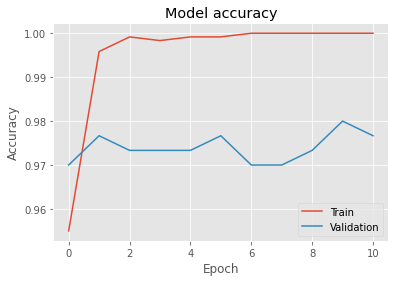

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [27]:
# load the best model
best_model_fn = keras.models.load_model('best_model_fn.h5')

In [28]:
# Get predictions
y_pred = best_model_fn.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

10/10 [==============================] - 1s 41ms/step

--- Confusion Matrix ---

[[ 94   0   1]
 [  1 102   4]
 [  0   0  98]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        95
           1       1.00      0.95      0.98       107
           2       0.95      1.00      0.98        98

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

